In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

Размер матрицы: (1308, 736)
Тип данных: float64
Диапазон значений: [0.0, 255.0]
Пример значений:
[[153. 155. 158.]
 [153. 155. 159.]
 [158. 160. 163.]]


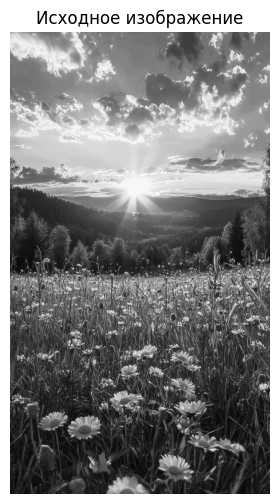

In [2]:
# Загрузка изображения и преобразование в ч/б
image = Image.open('nature.jpg').convert('L')
image_array = np.array(image, dtype=float)

print(f"Размер матрицы: {image_array.shape}")
print(f"Тип данных: {image_array.dtype}")
print(f"Диапазон значений: [{image_array.min()}, {image_array.max()}]")
print(f"Пример значений:\n{image_array[:3, :3]}")

plt.figure(figsize=(8, 6))
plt.imshow(image_array, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')
plt.show()

Всего FFT коэффициентов: 962688
Размер изображения: (1308, 736)
Размер FFT массива: (1308, 736)


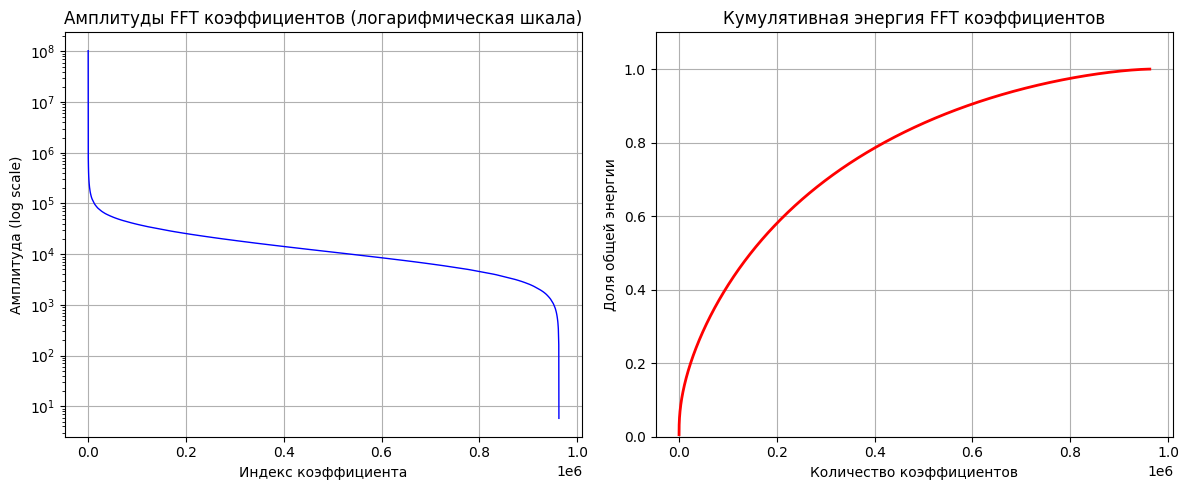

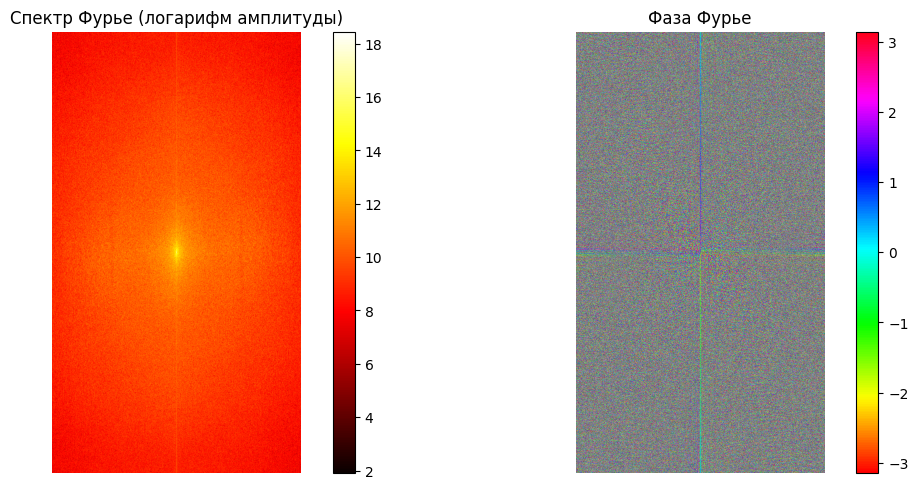

In [10]:
# Выполняем FFT
fft_transform = np.fft.fft2(image_array.astype(float))
fft_shifted = np.fft.fftshift(fft_transform)

# Вычисляем амплитуды
magnitudes = np.abs(fft_transform)
magnitudes_flat = magnitudes.ravel()
magnitudes_sorted = np.sort(magnitudes_flat)[::-1]# Сортируем по убыванию

# Общее количество коэффициентов
total_coeffs = len(magnitudes_sorted)
print(f"Всего FFT коэффициентов: {total_coeffs}")
print(f"Размер изображения: {image_array.shape}")
print(f"Размер FFT массива: {fft_transform.shape}")

# Вычисляем кумулятивную энергию
cumulative_energy = np.cumsum(magnitudes_sorted) / np.sum(magnitudes_sorted)

# График амплитуд коэффициентов и кумулятивной энергии
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(magnitudes_sorted, 'b-', linewidth=1)
plt.title('Амплитуды FFT коэффициентов (логарифмическая шкала)')
plt.xlabel('Индекс коэффициента')
plt.ylabel('Амплитуда (log scale)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cumulative_energy, 'r-', linewidth=2)
plt.title('Кумулятивная энергия FFT коэффициентов')
plt.xlabel('Количество коэффициентов')
plt.ylabel('Доля общей энергии')
plt.grid(True)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Визуализация спектра
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
magnitude_spectrum = np.log(1 + np.abs(fft_shifted))
plt.imshow(magnitude_spectrum, cmap='hot')
plt.title('Спектр Фурье (логарифм амплитуды)')
plt.axis('off')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.angle(fft_shifted), cmap='hsv')
plt.title('Фаза Фурье')
plt.axis('off')
plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
# === ФУНКЦИИ ДЛЯ FFT СЖАТИЯ ===

def compress_fft(fft_coeffs, keep_ratio):
    """
    Сжатие FFT коэффициентов - сохранение только максимальных по амплитуде коэффициентов
    """
    magnitudes = np.abs(fft_coeffs)
    
    total_coeffs = fft_coeffs.size
    keep_count = int(total_coeffs * keep_ratio)
    
    # Находим пороговое значение
    threshold = np.partition(magnitudes.ravel(), -keep_count)[-keep_count]
    
    mask = magnitudes >= threshold
    compressed_fft = fft_coeffs * mask
    
    return compressed_fft, mask, keep_count

def reconstruct_from_fft(compressed_fft):
    """Восстановление изображения из сжатых FFT коэффициентов"""
    reconstructed = np.fft.ifft2(compressed_fft).real
    reconstructed = np.clip(reconstructed, 0, 255)
    return reconstructed.astype(np.uint8)


РЕЗУЛЬТАТЫ СЖАТИЯ С ПОМОЩЬЮ FFT
Уровень    Коэфф.   % энергии    Ошибка Фробениуса   
------------------------------------------------------------
10%        96268    40.40     % 14949.36            
5%         48134    28.39     % 18213.20            
1%         9626     13.23     % 23546.12            
0.2%       1925     6.81      % 27512.30            


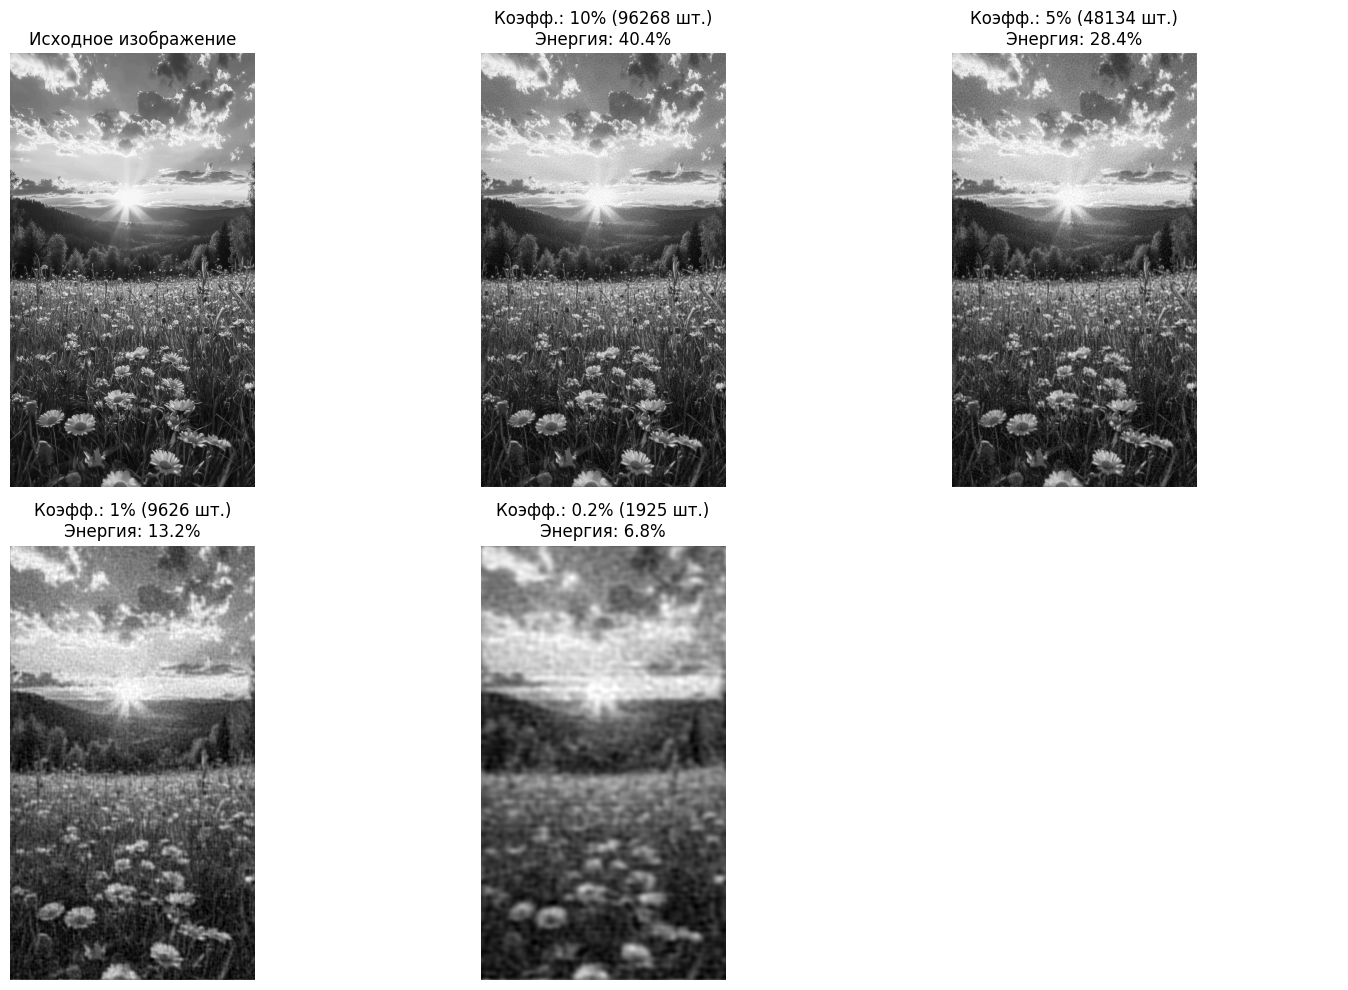

In [12]:
# === ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ СЖАТИЯ ===
compression_ratios = [0.10, 0.05, 0.01, 0.002]
ratios_names = ['10%', '5%', '1%', '0.2%']

print("\n" + "="*80)
print("РЕЗУЛЬТАТЫ СЖАТИЯ С ПОМОЩЬЮ FFT")
print("="*80)
print(f"{'Уровень':<10} {'Коэфф.':<8} {'% энергии':<12} {'Ошибка Фробениуса':<20}")
print("-" * 60)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

axes[0].imshow(image_array, cmap='gray')
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

for i, (ratio, name) in enumerate(zip(compression_ratios, ratios_names)):
    # Сжимаем FFT коэффициенты
    compressed_fft, mask, kept_coeffs = compress_fft(fft_transform, ratio)
    
    reconstructed = reconstruct_from_fft(compressed_fft)
    
    total_energy = np.sum(magnitudes_sorted)
    kept_energy = np.sum((np.abs(compressed_fft)))
    energy_percentage = (kept_energy / total_energy) * 100
    
    error_norm = np.linalg.norm(image_array - reconstructed, 'fro')
    
    print(f"{name:<10} {kept_coeffs:<8} {energy_percentage:<10.2f}% {error_norm:<20.2f}")
    
    axes[i+1].imshow(reconstructed, cmap='gray')
    axes[i+1].set_title(f'Коэфф.: {name} ({kept_coeffs} шт.)\nЭнергия: {energy_percentage:.1f}%')
    axes[i+1].axis('off')

if len(compression_ratios) + 1 < len(axes):
    for j in range(len(compression_ratios) + 1, len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()

In [13]:
# === АНАЛИЗ ЭФФЕКТИВНОСТИ СЖАТИЯ ===

print("\n" + "="*80)
print("ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ")
print("="*80)
print(f"Размер исходной матрицы: {image_array.shape}")
print(f"Общее количество элементов: {image_array.size}")
print(f"Размер FFT матрицы: {fft_transform.shape}")

# Экономия памяти для разных уровней сжатия
print("\nЭКОНОМИЯ ПАМЯТИ:")
print(f"{'Уровень':<10} {'Коэфф.':<8} {'Исходный размер':<18} {'Сжатый размер':<16} {'Коэф. сжатия':<12}")
print("-" * 70)

m, n = image_array.shape
for ratio, name in zip(compression_ratios, ratios_names):
    kept_coeffs = int(fft_transform.size * ratio)
    original_size = m * n * 2  # комплексные числа
    
    # Размер сжатого представления: храним только выбранные коэффициенты
    compressed_size = kept_coeffs * 2 + kept_coeffs * 2  # значения + позиции
    
    compression_ratio = original_size / compressed_size
    
    print(f"{name:<10} {kept_coeffs:<8} {original_size:<18} {compressed_size:<16} {compression_ratio:<10.2f}x")



ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ
Размер исходной матрицы: (1308, 736)
Общее количество элементов: 962688
Размер FFT матрицы: (1308, 736)

ЭКОНОМИЯ ПАМЯТИ:
Уровень    Коэфф.   Исходный размер    Сжатый размер    Коэф. сжатия
----------------------------------------------------------------------
10%        96268    1925376            385072           5.00      x
5%         48134    1925376            192536           10.00     x
1%         9626     1925376            38504            50.00     x
0.2%       1925     1925376            7700             250.05    x
